# Text Classification with traditionl ML algorithms

We are going to use the 20 Newsgroup data set (http://qwone.com/~jason/20Newsgroups/). The task we need to do is to classify documents in 20 given categories. **Train and test data are already splitted by default. Therefore, we will apply the same preprocessing steps for the train and test data simultaneously.**

## Libraries

Here we import all the libraries we will use during the process.

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import svm
import time
%matplotlib inline

In [183]:
#settings seaborn plots
sns.set(style="whitegrid")

## Transforming Raw Data

Documents are stored in different subdirectories. We need to extract the information for them in a format that suits better for modelling. For that purpose, we use **load_files()** method from sklearn and therefore divide the data into labels (target) and data (content).

In [184]:
#data directory for train set
DATA_DIR = "C:/Users/guill/Google Drive/2. Currently learning/0. Master Data Science/1. Semester/Machine Learning/Exercises/Repo2/ml_2020s_group32/exercise_3/data/20news-bydate-train"

#data directory for the test set
DATA_DIR_test = "C:/Users/guill/Google Drive/2. Currently learning/0. Master Data Science/1. Semester/Machine Learning/Exercises/Repo2/ml_2020s_group32/exercise_3/data/20news-bydate-test"

In [185]:
# divides data into labels (target) and (data) 
data = load_files(DATA_DIR, encoding = "utf-8", decode_error = "replace")

#we do the same for test data
data_test = load_files(DATA_DIR_test, encoding = "utf-8", decode_error = "replace")

In [186]:
#show labels encoded from train
data.target

array([ 9,  4, 11, ..., 16, 18,  4])

In [187]:
#show labels not encoded from train
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [188]:
#show content of the first text from train
data.data[0]

"From: cubbie@garnet.berkeley.edu (                               )\nSubject: Re: Cubs behind Marlins? How?\nArticle-I.D.: agate.1pt592$f9a\nOrganization: University of California, Berkeley\nLines: 12\nNNTP-Posting-Host: garnet.berkeley.edu\n\n\ngajarsky@pilot.njin.net writes:\n\nmorgan and guzman will have era's 1 run higher than last year, and\n the cubs will be idiots and not pitch harkey as much as hibbard.\n castillo won't be good (i think he's a stud pitcher)\n\n       This season so far, Morgan and Guzman helped to lead the Cubs\n       at top in ERA, even better than THE rotation at Atlanta.\n       Cubs ERA at 0.056 while Braves at 0.059. We know it is early\n       in the season, we Cubs fans have learned how to enjoy the\n       short triumph while it is still there.\n"

As seen, now the data is in a more suitable format for further maniulations. Prior to the modelling step, we will transform everything to a single data frame (one for train and one for test). However, for the Exploratory Data Analysis, we will keep this format.

## Exploratory Data Analysis (EDA)

For the EDA we focus **only on the train data**. This way, we leave the test data completly unseen and we will use it only for testing the model.

First of all, we check some possible **class imbalances:**

In [189]:
#calculate the count of each category
labels, counts = np.unique(data.target, return_counts = True)

In [190]:
#convert encoded labels to strings
labels_str = np.array(data.target_names)[labels]

#store in a dictionary
dict_counts = dict(zip(labels_str, counts))

In [191]:
#transform dict to dataframe and transpose
df_counts = pd.DataFrame(dict_counts, index = ["count"]).T

In [192]:
#set index as column
df_counts.reset_index(level=0, inplace = True)

#sort by count
df_counts = df_counts.sort_values(by="count")

#show
df_counts

index  count
19        talk.religion.misc    377
18        talk.politics.misc    465
0                alt.atheism    480
16        talk.politics.guns    546
17     talk.politics.mideast    564
4      comp.sys.mac.hardware    578
1              comp.graphics    584
6               misc.forsale    585
3   comp.sys.ibm.pc.hardware    590
2    comp.os.ms-windows.misc    591
12           sci.electronics    591
5             comp.windows.x    593
14                 sci.space    593
7                  rec.autos    594
13                   sci.med    594
11                 sci.crypt    595
9         rec.sport.baseball    597
8            rec.motorcycles    598
15    soc.religion.christian    599
10          rec.sport.hockey    600

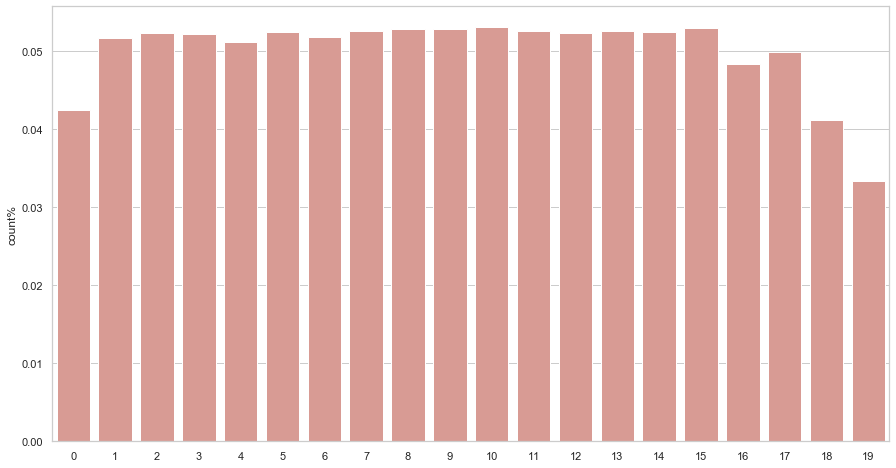

In [193]:
#show count of classes as %

#1st add column with %
df_counts["count%"] = df_counts["count"]/df_counts["count"].sum()

#2nd plot
plt.figure(figsize=(15,8))
sns.barplot(x=df_counts.index, y="count%", data=df_counts, color="salmon", saturation=0.5);

Classes are **reasonably balanced**. Just the classes 1 (alt.atheism), 18 (talk.politics.misc) and 19 (talk.religion.misc)  have fewer observations. However these differences shouldn't be a problem. Therefore, it is not necessary to undersample majority classes or oversample the minority ones. 

To get a better understanding of our data, it may be interesting to see the **distribution of the length of all the texts.** For that purpose, we store the lenght of every text in a list and plot them with a distribution plot.

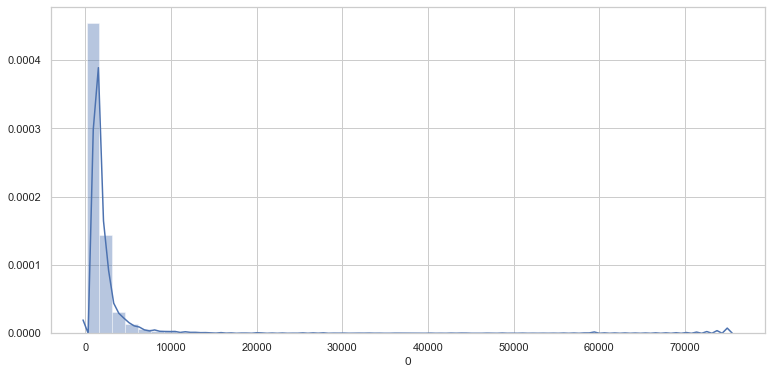

In [194]:
length_texts = []

#loop over all the texts
for i in range(len(data.data)):
    length_texts.append(len(data.data[i]))

#store list in a df
length_texts = pd.DataFrame(length_texts)

#distribution plot
plt.figure(figsize=(12.8,6))
sns.distplot(length_texts[0]);

Let's remove from the 95% onwards to better appreciate the distplot.

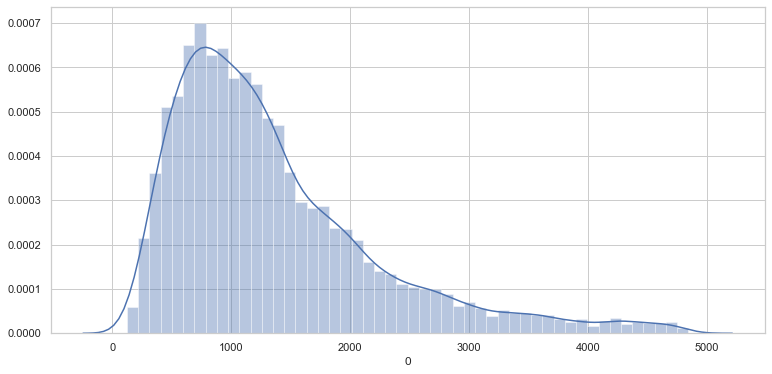

In [195]:
#remove 95%
quantile_95 = length_texts.quantile(0.95)
length_texts_95 = length_texts[length_texts < quantile_95]

#distribution plot
plt.figure(figsize=(12.8,6))
sns.distplot(length_texts_95[0]);

We can observe that (after removing the top 5% percentile) most of the texts have a length between 0 and 2000 words (reaching its peak a bit below 1000). For better understanding of the data, it may be also useful to print a summary with respect to the length.

In [196]:
#summary
length_texts.describe()

0
count  11314.000000
mean    1949.310058
std     4159.979767
min      125.000000
25%      753.250000
50%     1178.000000
75%     1881.000000
max    75154.000000

Note that the mean is close to 2000 while the median is around 1000. This goes in line with what we show in the distplot of the whole data. The data presents a strong **right-skewness.**

## Feature Engineering

In order to perform the classification task, we need to transform the text to some numeric encoding. We wil use the TF-IDF vectorizer approach for this purpose. However, prior to do so, we will get rid of some useless special characters and punctuation signs and we will downcase all the words.

### Text cleaning

We must perform this cleaning to avoid distorsions in the model.

#### 1. Special character cleaning

Train data:

In [197]:
# removing \r, \n, \t quotes and useless spaces
for i in range(len(data.data)):
    for j in ["\r", "\n", "   ", "\t" "''", "\ " ]:
        data.data[i] = data.data[i].replace(j, " ")

#show first document after cleaning special characters
data.data[0]

"From: cubbie@garnet.berkeley.edu (           ) Subject: Re: Cubs behind Marlins? How? Article-I.D.: agate.1pt592$f9a Organization: University of California, Berkeley Lines: 12 NNTP-Posting-Host: garnet.berkeley.edu gajarsky@pilot.njin.net writes:  morgan and guzman will have era's 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won't be good (i think he's a stud pitcher)   This season so far, Morgan and Guzman helped to lead the Cubs    at top in ERA, even better than THE rotation at Atlanta.    Cubs ERA at 0.056 while Braves at 0.059. We know it is early    in the season, we Cubs fans have learned how to enjoy the    short triumph while it is still there. "

Test data (we don't print test data to leave it completly unseen):

In [198]:
# removing \r, \n, \t quotes and useless spaces
for i in range(len(data_test.data)):
    for j in ["\r", "\n", "   ", "\t" "''", "\ " ]:
        data_test.data[i] = data_test.data[i].replace(j, " ")

#### 2. Downcase

Downcase the texts because we want "Subject" and "subject" to be the same word.

Train:

In [199]:
#downcase
for i in range(len(data.data)):
    data.data[i] = data.data[i].lower()
    
#show after
data.data[0]

"from: cubbie@garnet.berkeley.edu (           ) subject: re: cubs behind marlins? how? article-i.d.: agate.1pt592$f9a organization: university of california, berkeley lines: 12 nntp-posting-host: garnet.berkeley.edu gajarsky@pilot.njin.net writes:  morgan and guzman will have era's 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won't be good (i think he's a stud pitcher)   this season so far, morgan and guzman helped to lead the cubs    at top in era, even better than the rotation at atlanta.    cubs era at 0.056 while braves at 0.059. we know it is early    in the season, we cubs fans have learned how to enjoy the    short triumph while it is still there. "

Test: 

In [200]:
#downcase
for i in range(len(data_test.data)):
    data_test.data[i] = data_test.data[i].lower()

#### 3. Punctuation signs

They don't have predicting power. Thus, remove.

Train:

In [201]:
# removing punctuation signs
for i in range(len(data.data)):
    for j in ["?", ".", "(", ")", ":", ";", "#", ",", "!", "'s", "'t", ">", "|", "]", "[", "-", "=", "@", "email", "mail", "uk", "usa", "00"]: #remove also possesive pronouns terminations and other words we realized we don't need
        data.data[i] = data.data[i].replace(j, " ")

#show first document after cleaning special characters
data.data[0]

'from  cubbie garnet berkeley edu               subject  re  cubs behind marlins  how  article i d   agate 1pt592$f9a organization  university of california  berkeley lines  12 nntp posting host  garnet berkeley edu gajarsky pilot njin net writes   morgan and guzman will have era  1 run higher than last year  and  the cubs will be idiots and not pitch harkey as much as hibbard   castillo won  be good  i think he  a stud pitcher    this season so far  morgan and guzman helped to lead the cubs    at top in era  even better than the rotation at atlanta     cubs era at 0 056 while braves at 0 059  we know it is early    in the season  we cubs fans have learned how to enjoy the    short triumph while it is still there  '

Test: 

In [202]:
# removing punctuation signs
for i in range(len(data_test.data)):
    for j in ["?", ".", "(", ")", ":", ";", "#", ",", "!", "'s", "'t", ">", "|", "]", "[", "-", "=", "@", "email", "mail", "uk", "usa", "00"]: #remove also possesive pronouns terminations and other words we realized we don't need
        data_test.data[i] = data_test.data[i].replace(j, " ")

#### 4. Train-test

As we said before, the train-test split was already done. However, prior to apply the tf-idf vectorizer to both of them, we will transform them into conventional dataframes for better understanding.

Train:

In [203]:
#let's put everything a classical data frame for better manipulation in the text representation and modelling
df = pd.DataFrame(data.target, columns=["target"])

#add content
df["content"] = data.data

#show
df

target                                            content
0           9  from  cubbie garnet berkeley edu              ...
1           4  from  gnelson pion rutgers edu  gregory nelson...
2          11  from  crypt comments math ncsu edu subject  cr...
3           4  from      subject  re  quadra scsi problems   ...
4           0  from  keith cco caltech edu  keith allan schne...
...       ...                                                ...
11309       8  from  rbemben timewarp prime com  rich bemben ...
11310       5  from  stevedav netcom com  steve davidson  sub...
11311      16  from   05111312 mci  com  peter nesbitt  subje...
11312      18  from  eck panix com  mark eckenwiler  subject ...
11313       4  from  lau aerospace aero org  david lau  subje...

[11314 rows x 2 columns]

Test (we don't show it to keep it completly unseen): 

In [204]:
#let's put everything a classical data frame for better manipulation in the text representation and modelling
df_test = pd.DataFrame(data_test.target, columns=["target"])

#add content
df_test["content"] = data_test.data

In [205]:
# Let's also separate the labels from the X
X_train = df["content"]
y_train = df["target"]

# test data
X_test = df_test["content"]
y_test = df_test["target"]

#### 5. Text Representation: TF-IDF Vectorized

Now, everything is ready to apply tf-idf vectorizer. Data will be transformed into a sparse matrix.

In [206]:
# Parameter election
ngram_range = (1,1) #use only unigrams
min_df = 10
max_df = 1.
max_features = 300
stop_words = "english"

In [207]:
#built the vectorizer
tfidf = TfidfVectorizer(
    encoding='utf-8',
    ngram_range=ngram_range,
    stop_words=stop_words,
    lowercase=False,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    norm='l2',
    sublinear_tf=True
)

#transform 
X_train = tfidf.fit_transform(X_train)

#only transform
X_test = tfidf.transform(X_test)

In [208]:
#see shapes
print(X_train.shape)
X_test.shape

(11314, 300)


(7532, 300)

Thanks to a code we found in https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb we can do a quick analysis using a Chi-squared test to see which unigrams and bigrams are most correlated with each cateogry. We do this **just for the train set.**

First we need to define a dict that matches each category with the encoding.

In [209]:
#define a dictionary that matches each category to 
category_codes = {
 'alt.atheism' : 0,
 'comp.graphics' : 1,
 'comp.os.ms-windows.misc' : 2 ,
 'comp.sys.ibm.pc.hardware' :3 ,
 'comp.sys.mac.hardware' : 4,
 'comp.windows.x' : 5,
 'misc.forsale' : 6,
 'rec.autos' : 7,
 'rec.motorcycles' : 8,
 'rec.sport.baseball' : 9,
 'rec.sport.hockey' : 10,
 'sci.crypt' : 11,
 'sci.electronics' : 12,
 'sci.med' : 13,
 'sci.space' : 14,
 'soc.religion.christian' : 15,
 'talk.politics.guns' : 16,
 'talk.politics.mideast' : 17,
 'talk.politics.misc' : 18,
 'talk.religion.misc' : 19
}

Apply the chi-test to our data and see which unigrams are more correlated to each of the categories.

In [210]:
for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(X_train, y_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("")

# 'alt.atheism' category:
  . Most correlated unigrams:
. christian
. say
. evidence
. bible
. god

# 'comp.graphics' category:
  . Most correlated unigrams:
. file
. ftp
. files
. image
. graphics

# 'comp.os.ms-windows.misc' category:
  . Most correlated unigrams:
. ftp
. files
. file
. dos
. windows

# 'comp.sys.ibm.pc.hardware' category:
  . Most correlated unigrams:
. disk
. pc
. drive
. card
. scsi

# 'comp.sys.mac.hardware' category:
  . Most correlated unigrams:
. memory
. drive
. scsi
. apple
. mac

# 'comp.windows.x' category:
  . Most correlated unigrams:
. running
. code
. mit
. server
. window

# 'misc.forsale' category:
  . Most correlated unigrams:
. distribution
. 25
. interested
. price
. sale

# 'rec.autos' category:
  . Most correlated unigrams:
. buy
. hp
. speed
. price
. car

# 'rec.motorcycles' category:
  . Most correlated unigrams:
. ca
. mike
. com
. sun
. max

# 'rec.sport.baseball' category:
  . Most correlated unigrams:
. win
. year
. game
. games
. team

#

## Modelling

The following classification algorithms are going to be tried:
* Random Forest
* Support Vector Machines
* K_nearest neighbours
* Gradient Boosting
* Ridge Classifier

Following the recommendations of https://towardsdatascience.com/text-classification-in-python-dd95d264c802 the training methodology is going to be as follows:

For every algorithm: 

* Hyperparameters to tune
* Randomized Search Cross Validation in order to find the hyperparameter region in which we get higher **accuracy**
* Grid Search Cross Validation to exhaustively find the best combination of hyperparameters
* Evaluate in both train adn test data, extract classification report and build confusion matrix.

Finally, compare between the algorithms and choose the best one.

### Random Forest  

**Hyperparameters** to tune:

In [211]:
#hyperparameters --> grid taken from a example online

# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 5)]

# max_features
max_features = ['auto']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 80, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2]

# min_samples_leaf
min_samples_leaf = [1]

# bootstrap
bootstrap = [True]

#generate the grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

**Randomized search cross-validation:**

In [212]:
# First create the base model to tune with mtrk nummer as random state
rfc = RandomForestClassifier(random_state=11937906)

# Definition of the random search
random_search = RandomizedSearchCV(
                                   #set estimator to base model
                                   estimator=rfc,
                                   #use the grid generated above
                                   param_distributions=random_grid,
                                   n_iter=20,
                                   scoring = 'accuracy',
                                   #note that we do this first search just with 3 folds
                                   cv=3, 
                                   verbose=1, 
                                   random_state=11937906)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 60.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [213]:
print("The best hyperparameters from Random Search cross validation are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search cross validation are:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 65, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.6239169523063913


Now, we can proceed with the **Grid Search** based on the values we got above. 

In [214]:
n_estimators = [500]
min_samples_split = [2,4]
max_features = ["auto"]
min_samples_leaf = [1,2,3]
max_depth = [50,65]
bootstrap = [True]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=11937906)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
#10 splits now!
cv_sets = ShuffleSplit(n_splits = 10, test_size = .1, random_state = 11937906)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 209.5min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=11937906, test_size=0.1,
       train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              mi...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                           

In [215]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': True, 'max_depth': 65, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

The mean accuracy of a model with these hyperparameters is:
0.6349823321554771


In [216]:
best_rfc = grid_search.best_estimator_

In [217]:
best_rfc

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=65, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=11937906,
                       verbose=0, warm_start=False)

Fit best model to the training data:

In [218]:
best_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=65, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=11937906,
                       verbose=0, warm_start=False)

Get and save predictions:

In [219]:
rfc_pred = best_rfc.predict(X_test)

Training and test accuracy

In [220]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(y_train, best_rfc.predict(X_train)))


# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, rfc_pred))

The training accuracy is: 
0.999734841788934
The test accuracy is: 
0.5403611258629846


In [221]:
# Classification report
print("Classification report")
print(classification_report(y_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.45      0.33      0.38       319
           1       0.51      0.53      0.52       389
           2       0.61      0.65      0.63       394
           3       0.48      0.49      0.49       392
           4       0.63      0.58      0.60       385
           5       0.54      0.49      0.51       395
           6       0.71      0.66      0.69       390
           7       0.66      0.50      0.57       396
           8       0.38      0.54      0.44       398
           9       0.39      0.47      0.42       397
          10       0.59      0.67      0.63       399
          11       0.82      0.75      0.78       396
          12       0.29      0.33      0.31       393
          13       0.30      0.37      0.33       396
          14       0.68      0.66      0.67       394
          15       0.66      0.79      0.72       398
          16       0.59      0.43      0.50       364
     

We also do a heatmap with the confusion matrix:

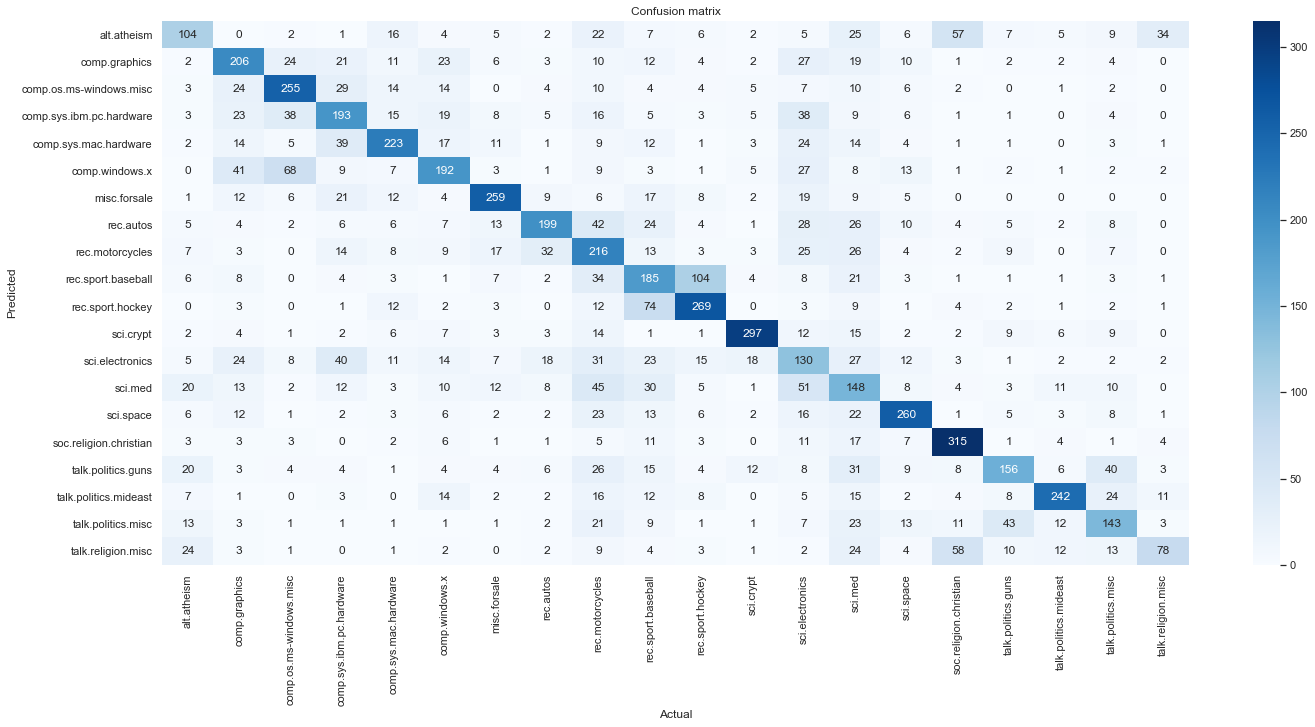

In [222]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, rfc_pred)
plt.figure(figsize=(23,10))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels = category_codes.keys(),
            yticklabels = category_codes.keys(),
            cmap="Blues",
            fmt = "g")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
#save confusion matrix
plt.savefig("target/rfc_confusion_matrix.png")
plt.show()

Dataset summary to compare afterwards:

In [223]:
#to join it later with other dataframes
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy ': accuracy_score(y_train, best_rfc.predict(X_train)),
     'Test Set Accuracy ': accuracy_score(y_test, rfc_pred),
     #since classes are balanced we don't care so much about using macro or micro averages
     "Test Precision " : precision_score(y_test, rfc_pred, average="macro"),
     "Test Recall " : recall_score(y_test, rfc_pred, average="macro"),
     "Test F1 " : f1_score(y_test, rfc_pred, average="macro")
}

df_models_rfc = pd.DataFrame(d, index=[0])
df_models_rfc

Model  Training Set Accuracy   Test Set Accuracy   Test Precision   \
0  Random Forest                0.999735            0.540361          0.55375   

   Test Recall   Test F1   
0      0.533004  0.537778

### Support Vector Machines (SVM)

**Hyperparameters** tune:

In [225]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

**Randomized search cross-validation:**

In [226]:
# First create the base model to tune using as a random state the mtrkl nummer
svc = svm.SVC(random_state=11937906)

# Definition of the random search
random_search = RandomizedSearchCV(#set SVM as estimator
                                   estimator=svc,
                                   #use the grid from above
                                   param_distributions=random_grid,
                                   n_iter=20,
                                   scoring='accuracy',
                                   #just 3 folds
                                   cv=3, 
                                   verbose=1, 
                                   random_state=11937906)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 161.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=11937906,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=20, n_jobs=None,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   pre_dispatch='2*n_jobs', random_sta

In [227]:
print("The best hyperparameters from Random Search cross validation are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search cross validation are:
{'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 2, 'C': 0.001}

The mean accuracy of a model with these hyperparameters is:
0.7036422357409559


Now, we can proceed with the **Grid Search** based on the values we got above. 

In [228]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01]
degree = [1, 2]
gamma = [10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['poly'], 'degree':degree, 'gamma':gamma, 'probability':probability},
]

# Create a base model
svc = svm.SVC(random_state=11937906)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
#10 folds!
cv_sets = ShuffleSplit(n_splits = 10, test_size = .1, random_state = 11937906)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 505.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=11937906, test_size=0.1,
       train_size=None),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=11937906,
                           shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.0001, 0.001, 0.01], 'degree': [1, 2],
                          'gamma': [10, 100], 'kernel': ['poly'],
                          'probability': [True]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [229]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.001, 'degree': 2, 'gamma': 100, 'kernel': 'poly', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.727208480565371


In [230]:
#save best and show
best_svc = grid_search.best_estimator_
best_svc

SVC(C=0.001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=100, kernel='poly',
    max_iter=-1, probability=True, random_state=11937906, shrinking=True,
    tol=0.001, verbose=False)

Fit to the training data:

In [231]:
best_svc.fit(X_train, y_train)

SVC(C=0.001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=100, kernel='poly',
    max_iter=-1, probability=True, random_state=11937906, shrinking=True,
    tol=0.001, verbose=False)

Predict:

In [232]:
svc_pred = best_svc.predict(X_test)

In [233]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(y_train, best_svc.predict(X_train)))


# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, svc_pred))

The training accuracy is: 
0.9994696835778681
The test accuracy is: 
0.5734200743494424


In [234]:
# Classification report
print("Classification report")
print(classification_report(y_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.44      0.53      0.48       319
           1       0.49      0.58      0.53       389
           2       0.68      0.61      0.64       394
           3       0.49      0.55      0.52       392
           4       0.62      0.59      0.61       385
           5       0.60      0.55      0.58       395
           6       0.69      0.70      0.70       390
           7       0.58      0.55      0.57       396
           8       0.45      0.62      0.52       398
           9       0.47      0.52      0.50       397
          10       0.69      0.65      0.67       399
          11       0.87      0.74      0.80       396
          12       0.35      0.39      0.37       393
          13       0.33      0.35      0.34       396
          14       0.74      0.67      0.70       394
          15       0.72      0.72      0.72       398
          16       0.59      0.51      0.55       364
     

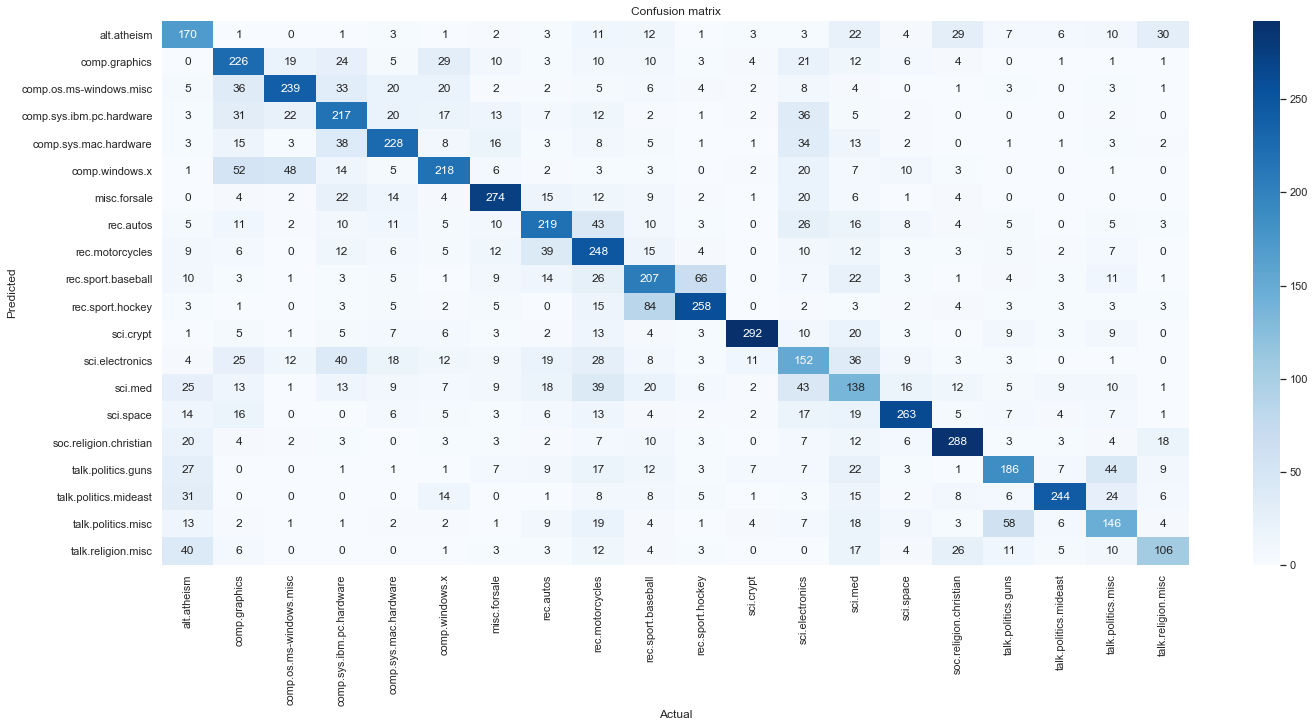

In [235]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, svc_pred)
plt.figure(figsize=(23,10))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels = category_codes.keys(),
            yticklabels = category_codes.keys(),
            cmap="Blues",
            fmt = "g")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.savefig("target/svm_confusion_matrix.png")
plt.show()

In [236]:
#to join it later with other dataframes
d = {
     'Model': 'Support Vector Machines',
     'Training Set Accuracy ': accuracy_score(y_train, best_svc.predict(X_train)),
     'Test Set Accuracy ': accuracy_score(y_test, svc_pred),
     #since classes are balanced we don't care so much about using macro or micro averages
     "Test Precision " : precision_score(y_test, svc_pred, average="macro"),
     "Test Recall " : recall_score(y_test, svc_pred, average="macro"),
     "Test F1 " : f1_score(y_test, svc_pred, average="macro")
}

df_models_svc = pd.DataFrame(d, index=[0])
df_models_svc

Model  Training Set Accuracy   Test Set Accuracy   \
0  Support Vector Machines                 0.99947             0.57342   

   Test Precision   Test Recall   Test F1   
0         0.585395      0.569093   0.57416

In [237]:
#save results
df_models_svc.to_csv("target/best_svc.csv")

### KNN

In this case, we will only tune the number of neighbours k. Thus, no randomized search is needed. We can directly start with the Grid Search:

In [238]:
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 500, num = 50)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 10, test_size = .1, random_state = 11937906)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=11937906, test_size=0.1,
       train_size=None),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 11, 21, 31, 41, 51, 62, 72, 82, 92,
                                         102, 113, 123, 133, 143, 153, 163, 174,
                                         184, 194, 204, 214, 225, 235, 245, 255,
                                         265, 275, 286, 296, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [239]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 1}

The mean accuracy of a model with these hyperparameters is:
0.6803886925795053


In [240]:
#save and show best estimator
best_knnc = grid_search.best_estimator_
best_knnc

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [241]:
#fit and predict
best_knnc.fit(X_train, y_train)
knnc_pred = best_knnc.predict(X_test)

In [242]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(y_train, best_knnc.predict(X_train)))

The training accuracy is: 
0.999734841788934


In [243]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, knnc_pred))

The test accuracy is: 
0.4754381306425916


In [244]:
# Classification report
print("Classification report")
print(classification_report(y_test,knnc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.42      0.51      0.46       319
           1       0.40      0.42      0.41       389
           2       0.54      0.53      0.54       394
           3       0.41      0.42      0.41       392
           4       0.43      0.41      0.42       385
           5       0.43      0.41      0.42       395
           6       0.51      0.57      0.54       390
           7       0.47      0.43      0.45       396
           8       0.47      0.52      0.49       398
           9       0.36      0.40      0.38       397
          10       0.54      0.59      0.57       399
          11       0.76      0.64      0.70       396
          12       0.33      0.33      0.33       393
          13       0.27      0.27      0.27       396
          14       0.60      0.56      0.58       394
          15       0.59      0.49      0.53       398
          16       0.55      0.52      0.53       364
     

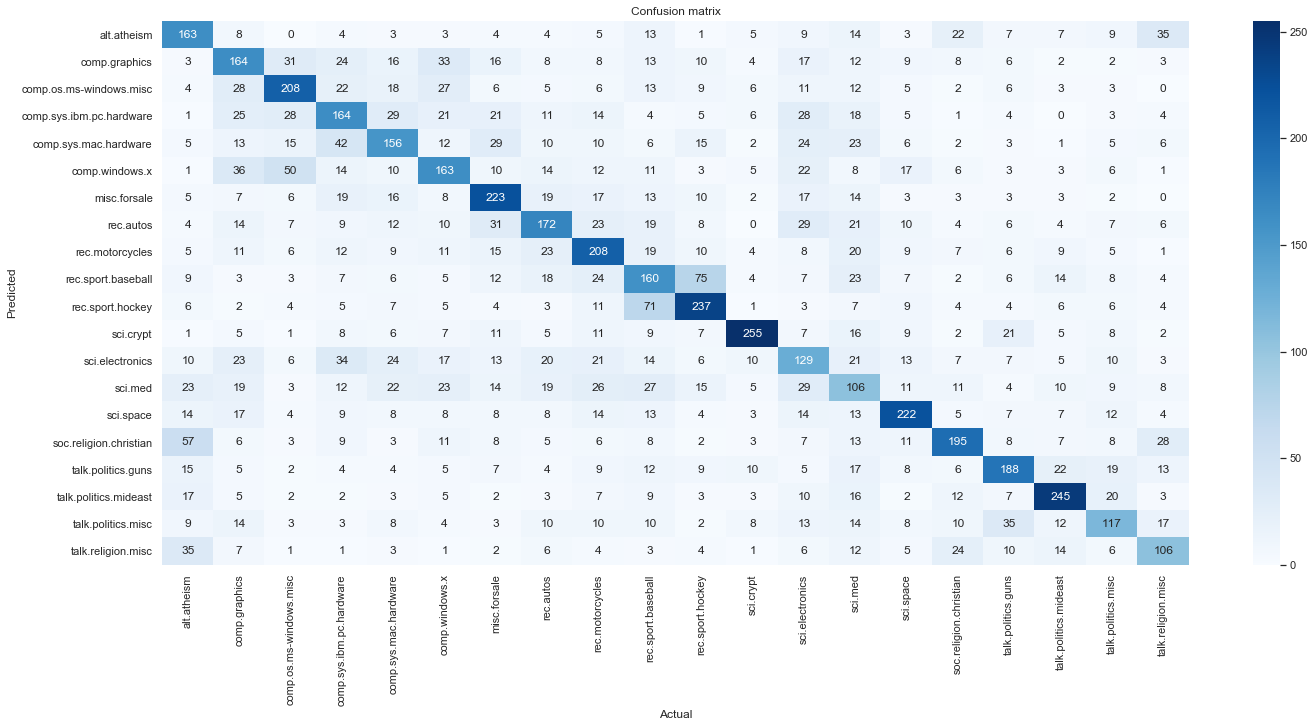

In [245]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, knnc_pred)
plt.figure(figsize=(23,10))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels = category_codes.keys(),
            yticklabels = category_codes.keys(),
            cmap="Blues",
            fmt = "g")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.savefig("target/knnc_confusion_matrix.png")
plt.show()

In [246]:
#to join it later with other dataframes
d = {
     'Model': 'K Nearest Neighbors',
     'Training Set Accuracy ': accuracy_score(y_train, best_knnc.predict(X_train)),
     'Test Set Accuracy ': accuracy_score(y_test, knnc_pred),
     #since classes are balanced we don't care so much about using macro or micro averages
     "Test Precision " : precision_score(y_test, knnc_pred, average="macro"),
     "Test Recall " : recall_score(y_test, knnc_pred, average="macro"),
     "Test F1 " : f1_score(y_test, knnc_pred, average="macro")
}

df_models_knnc = pd.DataFrame(d, index=[0])
df_models_knnc

Model  Training Set Accuracy   Test Set Accuracy   \
0  K Nearest Neighbors                0.999735            0.475438   

   Test Precision   Test Recall   Test F1   
0         0.478559      0.474177  0.475152

In [247]:
#save results
df_models_knnc.to_csv("target/best_knnc.csv")

### Gradient Boosting Machine

**Hyperparameters** to tune: 

In [248]:
# n_estimators
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               #'subsample': subsample
              }

**Randomized search cross-validation:**

In [249]:
# First create the base model to tune
clf = GradientBoostingClassifier(random_state=11937906)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=clf,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=11937906)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 586.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [250]:
print("The best hyperparameters from Random Search cross validation are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search cross validation are:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'learning_rate': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.6078307419302619


Now, we can proceed with the **Grid Search** based on the values we got above. 

In [251]:
max_depth = [None]
max_features = ['sqrt']
min_samples_leaf = [4]
min_samples_split = [10, 50]
n_estimators = [200]
learning_rate = [.1]
subsample = [1.]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=11937906)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 10, test_size = .1, random_state = 11937906)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 93.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=11937906, test_size=0.1,
       train_size=None),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  m...
                                                  subsample=1.0, tol=0.0001,
                                                  validation_fraction=

In [252]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.1, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 50, 'n_estimators': 200, 'subsample': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.6386925795053002


In [253]:
best_gbc = grid_search.best_estimator_
best_gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=None,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=11937906, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [254]:
#fit
best_gbc.fit(X_train, y_train)

#predict
gbc_pred = best_gbc.predict(X_test)

In [255]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(y_train, best_gbc.predict(X_train)))

# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, gbc_pred))

The training accuracy is: 
0.999734841788934
The test accuracy is: 
0.531465746149761


In [256]:
# Classification report
print("Classification report")
print(classification_report(y_test,gbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.40      0.39      0.40       319
           1       0.50      0.53      0.52       389
           2       0.60      0.64      0.62       394
           3       0.45      0.50      0.47       392
           4       0.56      0.63      0.59       385
           5       0.55      0.48      0.51       395
           6       0.66      0.68      0.67       390
           7       0.59      0.52      0.55       396
           8       0.44      0.49      0.46       398
           9       0.40      0.47      0.44       397
          10       0.59      0.62      0.60       399
          11       0.82      0.75      0.78       396
          12       0.30      0.27      0.28       393
          13       0.28      0.24      0.26       396
          14       0.59      0.66      0.63       394
          15       0.68      0.77      0.72       398
          16       0.50      0.47      0.48       364
     

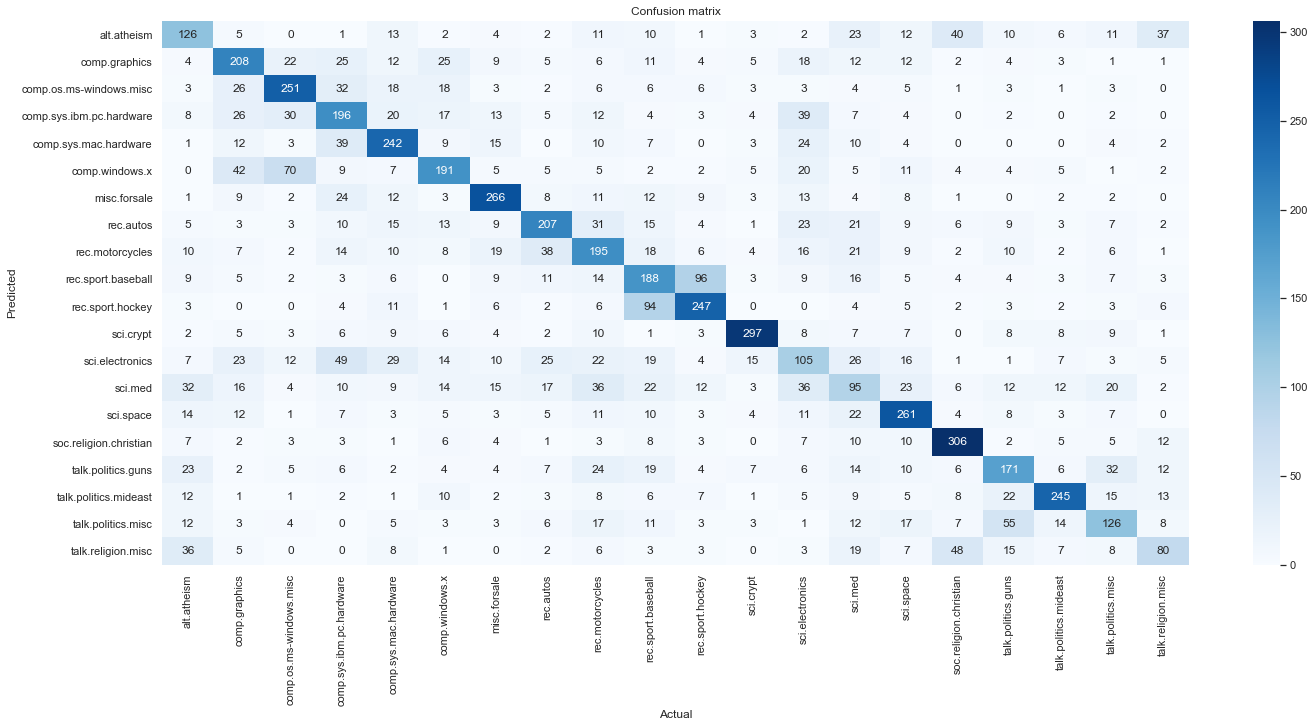

In [257]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, gbc_pred)
plt.figure(figsize=(23,10))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels = category_codes.keys(),
            yticklabels = category_codes.keys(),
            cmap="Blues",
            fmt = "g")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.savefig("target/gbc_confusion_matrix.png")
plt.show()

In [258]:
#to join it later with other dataframes
d = {
     'Model': 'Gradient Boosting Machines',
     'Training Set Accuracy ': accuracy_score(y_train, best_gbc.predict(X_train)),
     'Test Set Accuracy ': accuracy_score(y_test, gbc_pred),
     #since classes are balanced we don't care so much about using macro or micro averages
     "Test Precision " : precision_score(y_test, gbc_pred, average="macro"),
     "Test Recall " : recall_score(y_test, gbc_pred, average="macro"),
     "Test F1 " : f1_score(y_test, gbc_pred, average="macro")
}

df_models_gbc = pd.DataFrame(d, index=[0])
df_models_gbc

Model  Training Set Accuracy   Test Set Accuracy   \
0  Gradient Boosting Machines                0.999735            0.531466   

   Test Precision   Test Recall   Test F1   
0         0.526364      0.525055  0.524008

In [259]:
#save results
df_models_gbc.to_csv("target/best_gbc.csv")

### Ridge Classifier

In this case, we will use **do directly a exhaustive grid search with the parameters we also used in exercise 2.** They worked well for most of our classification tasks there. 

In [260]:
#hyperparameters
normalize = [False, True]
fit_intercept = [True, False]
alpha = [0, 1e-15, 1e-10, 1e-5, 1, 5, 10, 15]

#grid
grid = {'normalize': normalize,
               'fit_intercept': fit_intercept,
               'alpha': alpha}

In [261]:
# First create the base model to tune
clf = RidgeClassifier(random_state=11937906)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 10, test_size = .1, random_state = 11937906)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  2.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=11937906, test_size=0.1,
       train_size=None),
             error_score=nan,
             estimator=RidgeClassifier(alpha=1.0, class_weight=None,
                                       copy_X=True, fit_intercept=True,
                                       max_iter=None, normalize=False,
                                       random_state=11937906, solver='auto',
                                       tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0, 1e-15, 1e-10, 1e-05, 1, 5, 10, 15],
                         'fit_intercept': [True, False],
                         'normalize': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [262]:
print("The best hyperparameters from Random Search cross validation are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Random Search cross validation are:
{'alpha': 1e-10, 'fit_intercept': True, 'normalize': False}

The mean accuracy of a model with these hyperparameters is:
0.5920494699646642


Save the model as best Ridge Classifier estimator:

In [263]:
best_ridge = grid_search.best_estimator_

#show
best_ridge

RidgeClassifier(alpha=1e-10, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=11937906,
                solver='auto', tol=0.001)

Fit the model to the training data:

In [264]:
best_ridge.fit(X_train, y_train)

RidgeClassifier(alpha=1e-10, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=11937906,
                solver='auto', tol=0.001)

Get predictions from test:

In [265]:
ridge_pred = best_ridge.predict(X_test)

In [266]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(y_train, best_ridge.predict(X_train)))

The training accuracy is: 
0.635142301573272


In [267]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, ridge_pred))

The test accuracy is: 
0.5069038767923526


In [268]:
# Classification report
print("Classification report")
print(classification_report(y_test,ridge_pred))

Classification report
              precision    recall  f1-score   support

           0       0.33      0.29      0.31       319
           1       0.51      0.55      0.53       389
           2       0.59      0.63      0.61       394
           3       0.45      0.44      0.45       392
           4       0.56      0.58      0.57       385
           5       0.50      0.49      0.50       395
           6       0.71      0.65      0.68       390
           7       0.65      0.53      0.58       396
           8       0.36      0.42      0.39       398
           9       0.36      0.37      0.36       397
          10       0.53      0.67      0.59       399
          11       0.81      0.71      0.76       396
          12       0.28      0.29      0.29       393
          13       0.29      0.31      0.30       396
          14       0.62      0.67      0.65       394
          15       0.51      0.73      0.60       398
          16       0.54      0.41      0.46       364
     

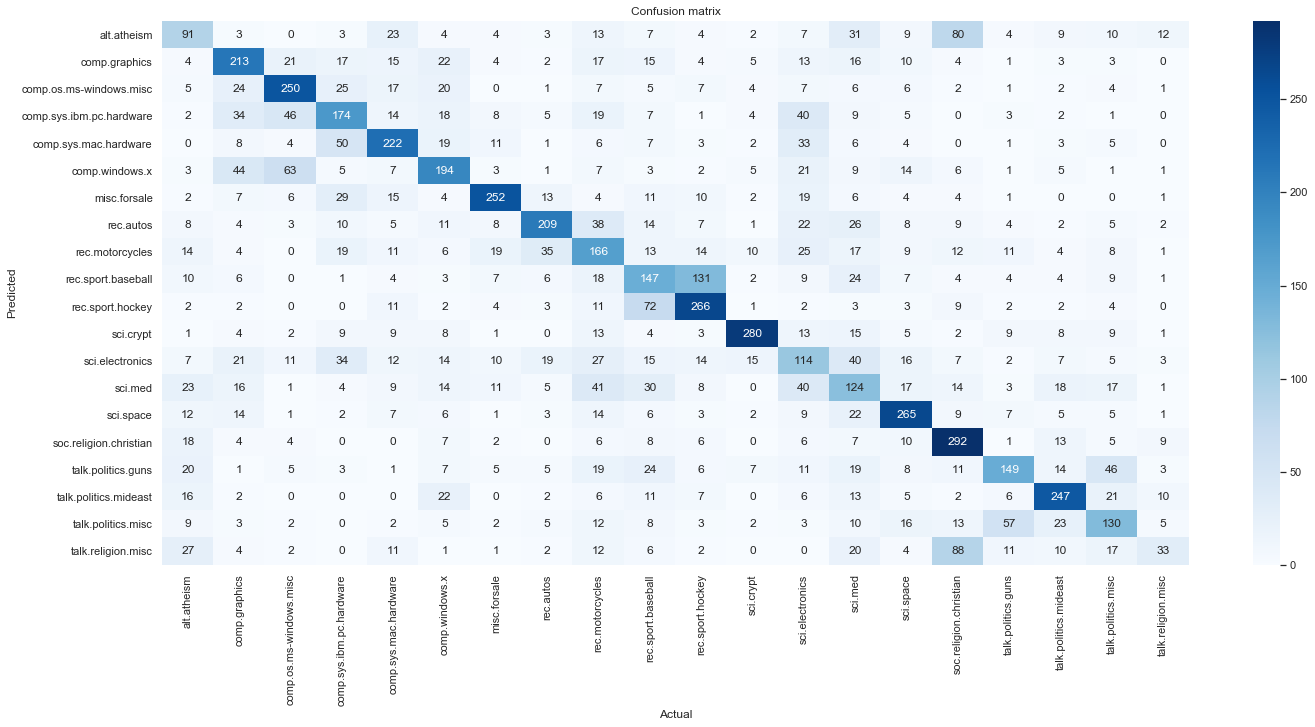

In [269]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, ridge_pred)
plt.figure(figsize=(23,10))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels = category_codes.keys(),
            yticklabels = category_codes.keys(),
            cmap="Blues",
            fmt = "g")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.savefig("target/ridge_confusion_matrix.png")
plt.show()

In [270]:
#to join it later with other dataframes
d = {
     'Model': 'Ridge Classifier',
     'Training Set Accuracy ': accuracy_score(y_train, best_ridge.predict(X_train)),
     'Test Set Accuracy ': accuracy_score(y_test, ridge_pred),
     #since classes are balanced we don't care so much about using macro or micro averages
     "Test Precision " : precision_score(y_test, ridge_pred, average="macro"),
     "Test Recall " : recall_score(y_test, ridge_pred, average="macro"),
     "Test F1 " : f1_score(y_test, ridge_pred, average="macro")
}

df_models_ridge = pd.DataFrame(d, index=[0])
df_models_ridge

Model  Training Set Accuracy   Test Set Accuracy   \
0  Ridge Classifier                0.635142            0.506904   

   Test Precision   Test Recall   Test F1   
0         0.504856      0.497028  0.495062

In [271]:
#save results
df_models_ridge.to_csv("target/Ridge_Classifier.csv")

## Comparing the models

In [272]:
#generate summary table
df_summary = pd.DataFrame()

for i in [df_models_svc, df_models_rfc, df_models_knnc,df_models_gbc, df_models_ridge]:
    df_summary = df_summary.append(i)
    
df_summary = df_summary.reset_index().drop('index', axis=1)

In [273]:
#show summary 
df_summary

Model  Training Set Accuracy   Test Set Accuracy   \
0     Support Vector Machines                0.999470            0.573420   
1               Random Forest                0.999735            0.540361   
2         K Nearest Neighbors                0.999735            0.475438   
3  Gradient Boosting Machines                0.999735            0.531466   
4            Ridge Classifier                0.635142            0.506904   

   Test Precision   Test Recall   Test F1   
0         0.585395      0.569093  0.574160  
1         0.553750      0.533004  0.537778  
2         0.478559      0.474177  0.475152  
3         0.526364      0.525055  0.524008  
4         0.504856      0.497028  0.495062

In [274]:
#sort by test accuracy
df_summary = df_summary.sort_values(by='Test Set Accuracy ', ascending=False)
df_summary.to_csv("target/summary.csv", sep=";")
df_summary

Model  Training Set Accuracy   Test Set Accuracy   \
0     Support Vector Machines                0.999470            0.573420   
1               Random Forest                0.999735            0.540361   
3  Gradient Boosting Machines                0.999735            0.531466   
4            Ridge Classifier                0.635142            0.506904   
2         K Nearest Neighbors                0.999735            0.475438   

   Test Precision   Test Recall   Test F1   
0         0.585395      0.569093  0.574160  
1         0.553750      0.533004  0.537778  
3         0.526364      0.525055  0.524008  
4         0.504856      0.497028  0.495062  
2         0.478559      0.474177  0.475152

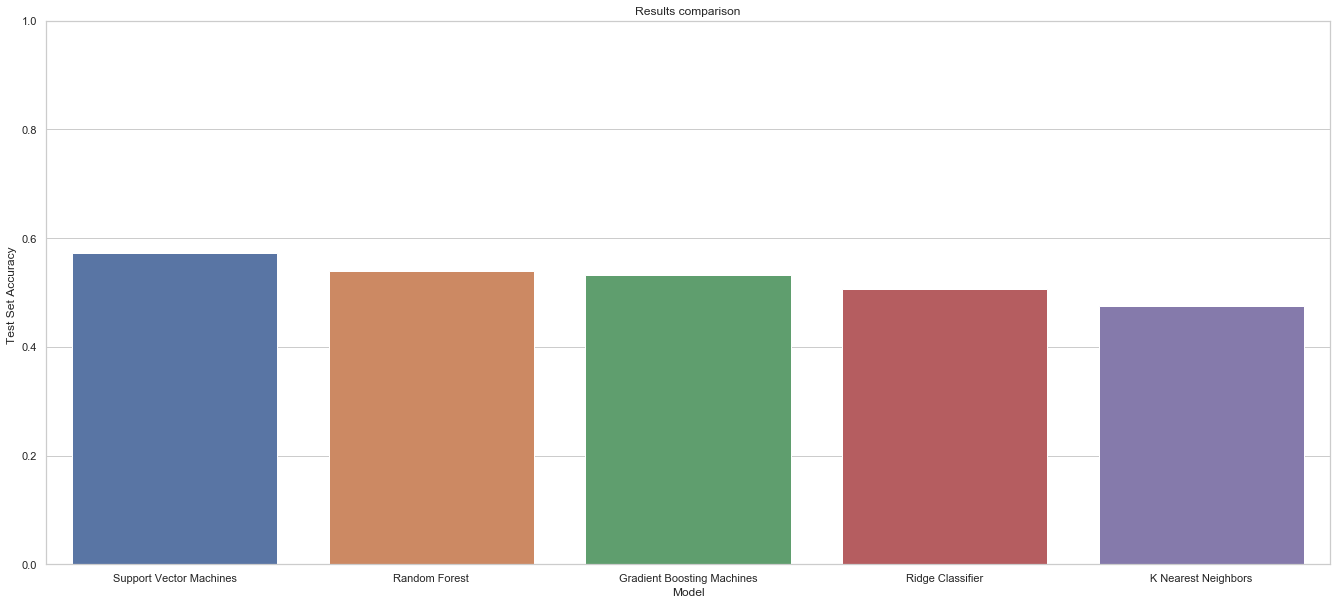

In [331]:
#see visually - "test accuracy"
plt.figure(figsize=(23,10))
sns.barplot(x="Model", y="Test Set Accuracy ", data=df_summary)
plt.title("Results comparison")
plt.ylim((0,1))
plt.savefig("target/results_test_accuracy_matrix.png")
plt.show();

As we can see, there are no big differences between model's test accuracy. However, the best one is Support Vector Machines. 

Same applies for precision and recall (zoom a bit to see better)

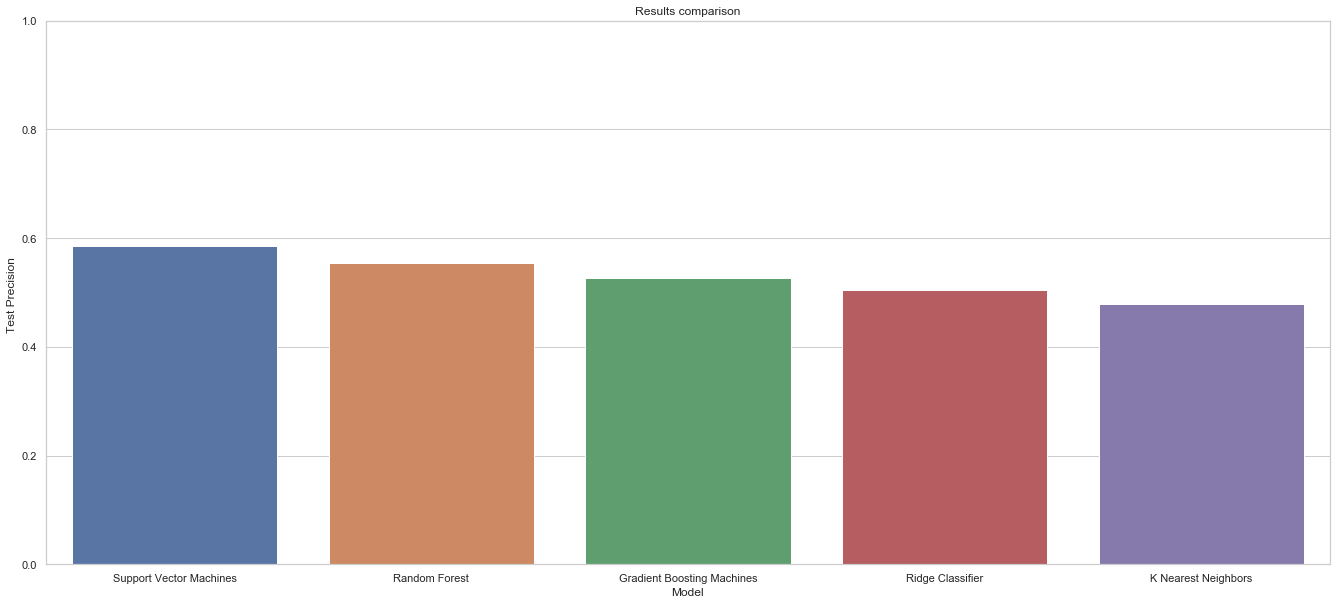

In [332]:
#see visually - "precision"
plt.figure(figsize=(23,10))
sns.barplot(x="Model", y="Test Precision ", data=df_summary)
plt.title("Results comparison")
plt.ylim((0,1))
plt.savefig("target/results_recall_precision_matrix.png")
plt.show();

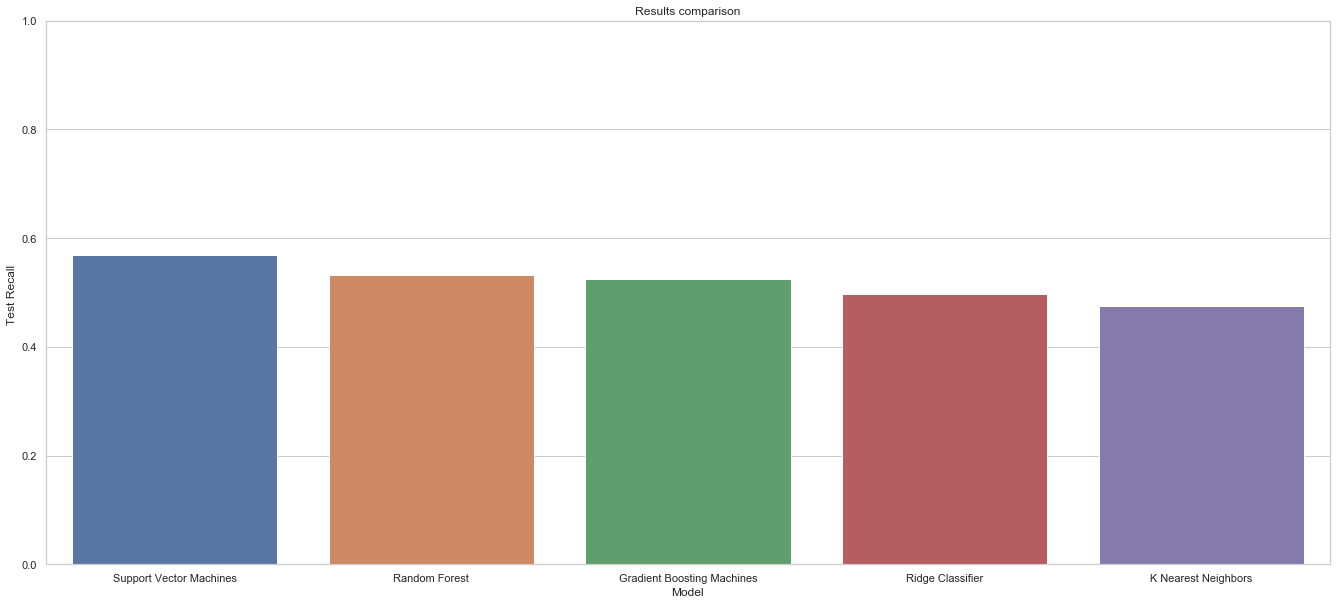

In [333]:
#see visually - "recall"
plt.figure(figsize=(23,10))
sns.barplot(x="Model", y="Test Recall ", data=df_summary)
plt.title("Results comparison")
plt.ylim((0,1))
plt.savefig("target/results_recall_matrix.png")
plt.show();

## Conclusions

* Support Vector Machines with the hyperparameters given by the grid search is the best algorithm to classify the news in the 20 given categories.
* Even though we are using 10-fold cross validation for the choice of the best combination of hyperparameters, the accuracy in the training set is very high for almost every model (overfitting?)
* Ridge regression does not give a high accuracy for the training set (WHY?) and neither for the test set.
* A baseline classifier would classify x% correct.
* Analyze by classes through confusion matrix (in report)
* This will serve as baseline for subsequent steps

## Further analysis

It is been proved that SVM is the best algorithm for the current dataset. However, we sticked to just 1 preprocessing (the one we thought was the most appropiate) from the raw data. It's possible that using different preprocessing may lead to different results. To do this properly, we should define a pipeline with different types of preprocessing and proceed with a random and grid search for each of them with each of the algorithms. This is obviously unfeasible and would be tedious to present. Therefore, we are going to stick to a couple of different ways of doing the preprocessing and we will see which accuracy we get when running them through the best_svc that we got before.

#### Preprocessing 0 - Original

In [277]:
#prepro 0 - the one we did already



#leads to the following results
df_prepro0 = df_models_svc
df_prepro0["Preprocessing"] = [0]
df_prepro0

Model  Training Set Accuracy   Test Set Accuracy   \
0  Support Vector Machines                 0.99947             0.57342   

   Test Precision   Test Recall   Test F1   Preprocessing  
0         0.585395      0.569093   0.57416              0

#### Preprocessing 1 - Just  default td-idf with english stop words

In [278]:
#prepro 1 - no character cleaning and using all the features in tf-idf vectorizer

#read original test and training

# divides data into labels (target) and (data) 
data = load_files(DATA_DIR, encoding = "utf-8", decode_error = "replace")

#we do the same for test data
data_test = load_files(DATA_DIR_test, encoding = "utf-8", decode_error = "replace")

In [279]:
#transform to a dataframe

#train
df1 = pd.DataFrame(data.target, columns=["target"])

#add content
df1["content"] = data.data

#show
display(df1)

#test
#let's put everything a classical data frame for better manipulation in the text representation and modelling
df_test1 = pd.DataFrame(data_test.target, columns=["target"])

#add content
df_test1["content"] = data_test.data

target                                            content
0           9  From: cubbie@garnet.berkeley.edu (            ...
1           4  From: gnelson@pion.rutgers.edu (Gregory Nelson...
2          11  From: crypt-comments@math.ncsu.edu\nSubject: C...
3           4  From:  ()\nSubject: Re: Quadra SCSI Problems??...
4           0  From: keith@cco.caltech.edu (Keith Allan Schne...
...       ...                                                ...
11309       8  From: rbemben@timewarp.prime.com (Rich Bemben)...
11310       5  From: stevedav@netcom.com (Steve Davidson)\nSu...
11311      16  From: 0005111312@mcimail.com (Peter Nesbitt)\n...
11312      18  From: eck@panix.com (Mark Eckenwiler)\nSubject...
11313       4  From: lau@aerospace.aero.org (David Lau)\nSubj...

[11314 rows x 2 columns]

In [280]:
# Let's also separate the labels from the X
X_train1 = df1["content"]
y_train1 = df1["target"]

# test data
X_test1 = df_test1["content"]
y_test1 = df_test1["target"]


#tf-idf

#built the vectorizer
tfidf = TfidfVectorizer(stop_words = "english")

#transform 
X_train1 = tfidf.fit_transform(X_train1)

#only transform
X_test1 = tfidf.transform(X_test1)

In [281]:
X_train1.shape

(11314, 129777)

In [282]:
#fit the model
best_svc.fit(X_train1, y_train1)

#and predict
svc_pred = best_svc.predict(X_test1)

In [283]:
#to join it later with other dataframes
d = {
     'Model': 'Support Vector Machines',
     'Training Set Accuracy ': accuracy_score(y_train1, best_svc.predict(X_train1)),
     'Test Set Accuracy ': accuracy_score(y_test1, svc_pred),
     #since classes are balanced we don't care so much about using macro or micro averages
     "Test Precision " : precision_score(y_test1, svc_pred, average="macro"),
     "Test Recall " : recall_score(y_test1, svc_pred, average="macro"),
     "Test F1 " : f1_score(y_test1, svc_pred, average="macro"),
     "Preprocessing" : 1
}

df_prepro1 = pd.DataFrame(d, index=[0])
df_prepro1

Model  Training Set Accuracy   Test Set Accuracy   \
0  Support Vector Machines                0.999735            0.740441   

   Test Precision   Test Recall   Test F1   Preprocessing  
0           0.8088      0.731685  0.750829              1

#### Preprocessing 2 - no cleaning but same params for tf-idf as in prepro0

In [284]:
### prepro 2 - no cleaning but same params for tf-idf vectorizer

#transform raw to a dataframe

#train
df2 = pd.DataFrame(data.target, columns=["target"])

#add content
df2["content"] = data.data

#show
display(df2)

#test
#let's put everything a classical data frame for better manipulation in the text representation and modelling
df_test2 = pd.DataFrame(data_test.target, columns=["target"])

#add content
df_test2["content"] = data_test.data

target                                            content
0           9  From: cubbie@garnet.berkeley.edu (            ...
1           4  From: gnelson@pion.rutgers.edu (Gregory Nelson...
2          11  From: crypt-comments@math.ncsu.edu\nSubject: C...
3           4  From:  ()\nSubject: Re: Quadra SCSI Problems??...
4           0  From: keith@cco.caltech.edu (Keith Allan Schne...
...       ...                                                ...
11309       8  From: rbemben@timewarp.prime.com (Rich Bemben)...
11310       5  From: stevedav@netcom.com (Steve Davidson)\nSu...
11311      16  From: 0005111312@mcimail.com (Peter Nesbitt)\n...
11312      18  From: eck@panix.com (Mark Eckenwiler)\nSubject...
11313       4  From: lau@aerospace.aero.org (David Lau)\nSubj...

[11314 rows x 2 columns]

In [285]:
# Let's also separate the labels from the X
X_train2 = df2["content"]
y_train2 = df2["target"]

# test data
X_test2 = df_test2["content"]
y_test2 = df_test2["target"]

#show
X_train2

0        From: cubbie@garnet.berkeley.edu (            ...
1        From: gnelson@pion.rutgers.edu (Gregory Nelson...
2        From: crypt-comments@math.ncsu.edu\nSubject: C...
3        From:  ()\nSubject: Re: Quadra SCSI Problems??...
4        From: keith@cco.caltech.edu (Keith Allan Schne...
                               ...                        
11309    From: rbemben@timewarp.prime.com (Rich Bemben)...
11310    From: stevedav@netcom.com (Steve Davidson)\nSu...
11311    From: 0005111312@mcimail.com (Peter Nesbitt)\n...
11312    From: eck@panix.com (Mark Eckenwiler)\nSubject...
11313    From: lau@aerospace.aero.org (David Lau)\nSubj...
Name: content, Length: 11314, dtype: object

In [286]:
# Parameter election
ngram_range = (1,1) #use unigrams
min_df = 10
max_df = 1.
max_features = 300
stop_words = "english"

In [287]:
#built the vectorizer
tfidf = TfidfVectorizer(
    encoding='utf-8',
    ngram_range=ngram_range,
    stop_words=stop_words,
    lowercase=False,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    norm='l2',
    sublinear_tf=True
)

#transform 
X_train2 = tfidf.fit_transform(X_train2)

#only transform
X_test2 = tfidf.transform(X_test2)

In [288]:
X_train2.shape

(11314, 300)

In [289]:
#fit the model
best_svc.fit(X_train2, y_train2)

#and predict
svc_pred = best_svc.predict(X_test2)

In [290]:
#to join it later with other dataframes
d = {
     'Model': 'Support Vector Machines',
     'Training Set Accuracy ': accuracy_score(y_train2, best_svc.predict(X_train2)),
     'Test Set Accuracy ': accuracy_score(y_test2, svc_pred),
     #since classes are balanced we don't care so much about using macro or micro averages
     "Test Precision " : precision_score(y_test2, svc_pred, average="macro"),
     "Test Recall " : recall_score(y_test2, svc_pred, average="macro"),
     "Test F2 " : f1_score(y_test2, svc_pred, average="macro"),
     "Preprocessing" : 2
}

df_prepro2 = pd.DataFrame(d, index=[0])
df_prepro2

Model  Training Set Accuracy   Test Set Accuracy   \
0  Support Vector Machines                0.999381            0.517127   

   Test Precision   Test Recall   Test F2   Preprocessing  
0           0.5289      0.513806  0.516932              2

#### Preprocessing 3 - Same cleaning, different params for tf-idf

In [291]:
#prepro 3

#retake cleaned dataframe from before
df3 = df
df_test3 = df_test

In [292]:
# Let's also separate the labels from the X
X_train3 = df3["content"]
y_train3 = df3["target"]

# test data
X_test3 = df_test3["content"]
y_test3 = df_test3["target"]

In [293]:
X_train3.shape

(11314,)

In [294]:
# NEW Parameter election
ngram_range = (1,2) #use unigrams and bigrams
min_df = 10
max_df = 1.
#use 500 features instead of 300
max_features = 500
stop_words = "english"

In [295]:
#built the vectorizer
tfidf = TfidfVectorizer(
    encoding='utf-8',
    ngram_range=ngram_range,
    stop_words=stop_words,
    lowercase=False,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    norm='l2',
    sublinear_tf=True
)

#transform 
X_train3 = tfidf.fit_transform(X_train3)

#only transform
X_test3 = tfidf.transform(X_test3)

In [296]:
X_train3.shape

(11314, 500)

In [297]:
#fit the model
best_svc.fit(X_train3, y_train3)

#and predict
svc_pred = best_svc.predict(X_test3)

In [298]:
#to join it later with other dataframes
d = {
     'Model': 'Support Vector Machines',
     'Training Set Accuracy ': accuracy_score(y_train3, best_svc.predict(X_train3)),
     'Test Set Accuracy ': accuracy_score(y_test3, svc_pred),
     #since classes are balanced we don't care so much about using macro or micro averages
     "Test Precision " : precision_score(y_test3, svc_pred, average="macro"),
     "Test Recall " : recall_score(y_test3, svc_pred, average="macro"),
     "Test F1 " : f1_score(y_test3, svc_pred, average="macro"),
     "Preprocessing" : 3
}

df_prepro3 = pd.DataFrame(d, index=[0])
df_prepro3

Model  Training Set Accuracy   Test Set Accuracy   \
0  Support Vector Machines                0.999558             0.63436   

   Test Precision   Test Recall   Test F3   Preprocessing  
0         0.646782      0.628242  0.633066              3

#### Preprocessing 4 - same cleaning but default tf-idf

In [299]:
# prepro 4 

#retake cleaned dataframe from before
df4 = df
df_test4 = df_test

In [300]:
# Let's also separate the labels from the X
X_train4 = df4["content"]
y_train4 = df4["target"]

# test data
X_test4 = df_test4["content"]
y_test4 = df_test4["target"]


#tf-idf

#built the vectorizer
tfidf = TfidfVectorizer(stop_words = "english")

#transform 
X_train4 = tfidf.fit_transform(X_train4)

#only transform
X_test4 = tfidf.transform(X_test4)

In [301]:
X_train4.shape

(11314, 128240)

In [302]:
#fit the model
best_svc.fit(X_train4, y_train4)

#and predict
svc_pred = best_svc.predict(X_test4)

In [312]:
#to join it later with other dataframes
d = {
     'Model': 'Support Vector Machines',
     'Training Set Accuracy ': accuracy_score(y_train4, best_svc.predict(X_train4)),
     'Test Set Accuracy ': accuracy_score(y_test4, svc_pred),
     #since classes are balanced we don't care so much about using macro or micro averages
     "Test Precision " : precision_score(y_test4, svc_pred, average="macro"),
     "Test Recall " : recall_score(y_test4, svc_pred, average="macro"),
     "Test F1 " : f1_score(y_test4, svc_pred, average="macro"),
     "Preprocessing" : 4
}

df_prepro4 = pd.DataFrame(d, index=[0])
df_prepro4

Model  Training Set Accuracy   Test Set Accuracy   \
0  Support Vector Machines                0.999646            0.737387   

   Test Precision   Test Recall   Test F1   Preprocessing  
0         0.812848      0.728632  0.750651              4

## What could have been improved? 

See report.

## Choose the best so far and use as a baseline

In [315]:
#solve a mistake on the naming of test F1
df_prepro2 = df_prepro2.rename(columns={"Test F2 " : "Test F1 "})
df_prepro3 = df_prepro3.rename(columns={"Test F3 " : "Test F1 "})

In [316]:
#join prepro df's results
df_summary1 = pd.DataFrame()

for i in [df_prepro0,df_prepro1,df_prepro2,df_prepro3,df_prepro4]:
    df_summary1 = df_summary1.append(i)
    
df_summary1 = df_summary1.reset_index().drop('index', axis=1)

df_summary1.to_csv("target/prepro.csv", sep =";", index=False)

In [318]:
df_summary1.sort_values(by="Test Set Accuracy ", ascending=False)

Model  Training Set Accuracy   Test Set Accuracy   \
1  Support Vector Machines                0.999735            0.740441   
4  Support Vector Machines                0.999646            0.737387   
3  Support Vector Machines                0.999558            0.634360   
0  Support Vector Machines                0.999470            0.573420   
2  Support Vector Machines                0.999381            0.517127   

   Test Precision   Test Recall   Test F1   Preprocessing  
1         0.808800      0.731685  0.750829              1  
4         0.812848      0.728632  0.750651              4  
3         0.646782      0.628242  0.633066              3  
0         0.585395      0.569093  0.574160              0  
2         0.528900      0.513806  0.516932              2

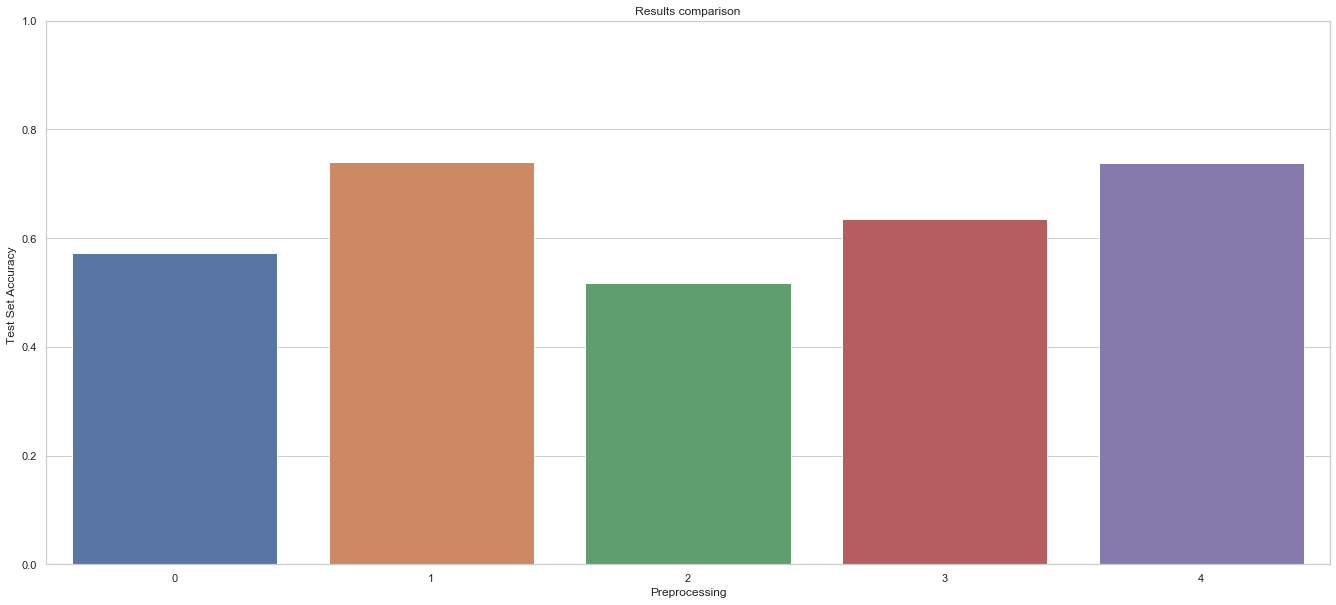

In [323]:
#see visually - "test accuracy"
plt.figure(figsize=(23,10))
sns.barplot(x="Preprocessing", y="Test Set Accuracy ", data=df_summary1)
plt.title("Results comparison")
plt.ylim((0,1))
plt.xticks((0,1,2,3,4))
plt.savefig("target/results_test_accuracy.png")
plt.show();

The best classifier so far is the combination of the best SVM that we found together with preprocessing 4. This one will be used as a baseline to compare with the deep learning results. For that purpose we will run it again, time it and save the results (including a confusion matrix):

In [334]:
#start time 
start = time.time()

#prepro 1 - no character cleaning and using all the features in tf-idf vectorizer

#read original test and training

# divides data into labels (target) and (data) 
data = load_files(DATA_DIR, encoding = "utf-8", decode_error = "replace")

#we do the same for test data
data_test = load_files(DATA_DIR_test, encoding = "utf-8", decode_error = "replace")


#transform to a dataframe

#train
df1 = pd.DataFrame(data.target, columns=["target"])

#add content
df1["content"] = data.data


#test
#let's put everything a classical data frame for better manipulation in the text representation and modelling
df_test1 = pd.DataFrame(data_test.target, columns=["target"])

#add content
df_test1["content"] = data_test.data

#fit the model
best_svc.fit(X_train1, y_train1)

#and predict
svc_pred = best_svc.predict(X_test1)

total_time = round(time.time() - start, 4)

In [335]:
df_prepro1["time"] = total_time

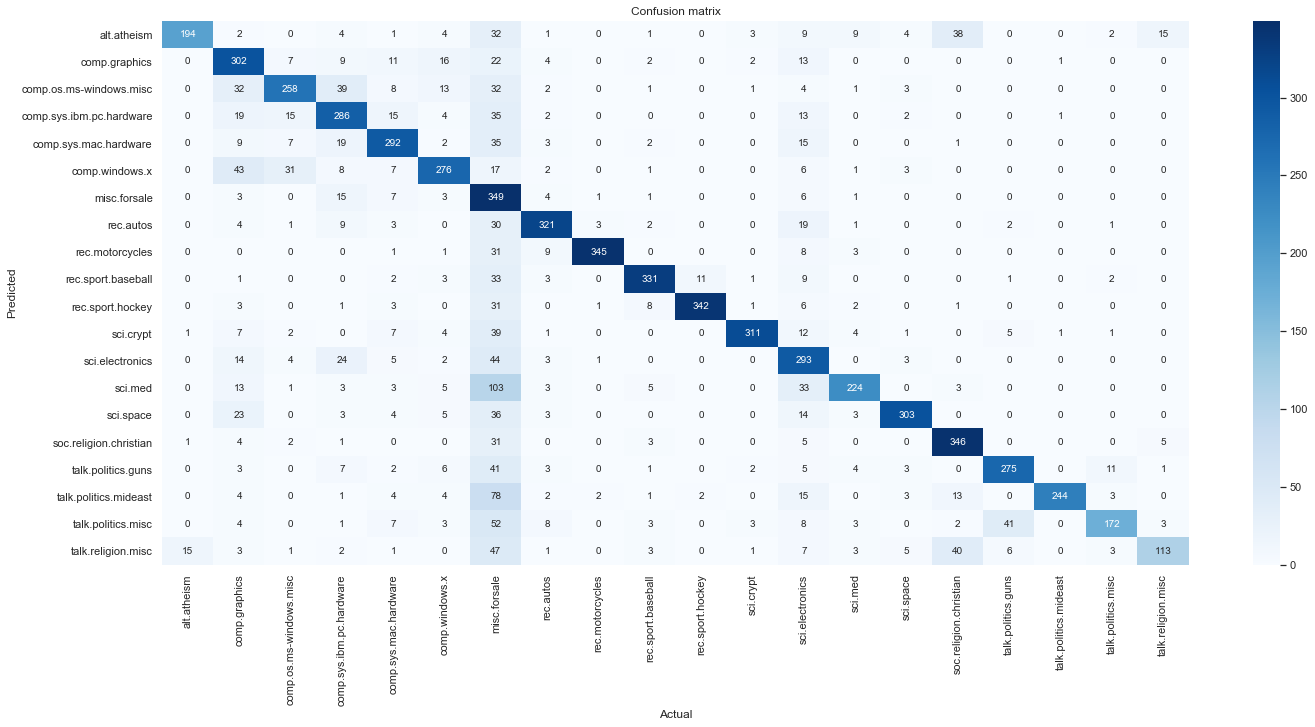

In [336]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, svc_pred)
plt.figure(figsize=(23,10))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels = category_codes.keys(),
            yticklabels = category_codes.keys(),
            cmap="Blues",
            fmt = "g")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
#save confusion matrix
plt.savefig("target/final_confusion_matrix.png")
plt.show()

In [337]:
# Classification report
print("Classification report")
print(classification_report(y_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       319
           1       0.61      0.78      0.68       389
           2       0.78      0.65      0.71       394
           3       0.66      0.73      0.69       392
           4       0.76      0.76      0.76       385
           5       0.79      0.70      0.74       395
           6       0.31      0.89      0.46       390
           7       0.86      0.81      0.83       396
           8       0.98      0.87      0.92       398
           9       0.91      0.83      0.87       397
          10       0.96      0.86      0.91       399
          11       0.96      0.79      0.86       396
          12       0.59      0.75      0.66       393
          13       0.86      0.57      0.68       396
          14       0.92      0.77      0.84       394
          15       0.78      0.87      0.82       398
          16       0.83      0.76      0.79       364
     

In [338]:
df_prepro1["Preprocessing"] = "No cleaning + default tf-idf with english stop words"

In [339]:
#show 
df_prepro1

Model  Training Set Accuracy   Test Set Accuracy   \
0  Support Vector Machines                0.999735            0.740441   

   Test Precision   Test Recall   Test F1   \
0           0.8088      0.731685  0.750829   

                                       Preprocessing       time  
0  No cleaning + default tf-idf with english stop...  1852.0072

In [341]:
df_prepro1.to_csv("target/BASELINE.csv")